# Importation des librairies

In [87]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os.path

from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from lifelines.utils import concordance_index



# Preprocessing

In [188]:
clinical_test=pd.read_csv('clinical_test.csv')
clinical_train=pd.read_csv('clinical_train.csv')

molecular_test=pd.read_csv('molecular_test.csv')
molecular_train=pd.read_csv('molecular_train.csv')


In [189]:
target_df=pd.read_csv('target_train.csv')

# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)


# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

In [190]:
def handle_missing_values(df):
    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype in [np.int64, np.float64]:
                # Numérique : remplacer par la médiane
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
            else:
                # Catégoriel : remplacer par 'Missing'
                df[col] = df[col].fillna('Missing')
    return df

In [191]:
import pandas as pd
import numpy as np

def aggregate_leukemia_data(df):
    """
    Agrégation simple des données de mutations par patient
    """
    
    # Gènes à haut risque
    high_risk_genes = ['TP53', 'ASXL1', 'RUNX1', 'FLT3', 'EZH2', 'DNMT3A', 'TET2', 'IDH1', 'IDH2']
    
    # Gènes à bon pronostic  
    good_genes = ['NPM1', 'CEBPA']
    
    # Effets délétères
    bad_effects = ['nonsense', 'frameshift', 'splice_site', 'stop_gained']
    

    # Agrégation de base
    result = df.groupby('ID').agg({
        'GENE': ['count', 'nunique'],
        'CHR': 'nunique',
        'VAF': ['mean', 'max', 'median'],
        'DEPTH': ['mean', 'min']
    }).reset_index()
    
    # Simplifier les noms de colonnes
    result.columns = ['ID', 'nb_mutations', 'nb_genes', 'nb_chromosomes', 
                      'vaf_mean', 'vaf_max', 'vaf_median', 'depth_mean', 'depth_min']
    
    # Ajouter les variables spécifiques
    for patient_id in result['ID']:
        patient_data = df[df['ID'] == patient_id]
        
        # Gènes à risque
        result.loc[result['ID'] == patient_id, 'nb_high_risk_genes'] = len(set(patient_data['GENE']) & set(high_risk_genes))
        
        
        # Effets délétères
        result.loc[result['ID'] == patient_id, 'nb_bad_effects'] = patient_data['EFFECT'].isin(bad_effects).sum()
        
        # Mutations importantes
        result.loc[result['ID'] == patient_id, 'has_TP53'] = int('TP53' in patient_data['GENE'].values)
        result.loc[result['ID'] == patient_id, 'has_FLT3'] = int('FLT3' in patient_data['GENE'].values)
        result.loc[result['ID'] == patient_id, 'has_good_gene'] = int(bool(set(patient_data['GENE']) & set(good_genes)))

        
        # VAF élevée (charge mutationelle)
        result.loc[result['ID'] == patient_id, 'nb_high_vaf'] = (patient_data['VAF'] > 0.4).sum()
    
    # Score de risque simple
    result['risk_score'] = (result['nb_high_risk_genes'] * 2 + 
                           result['nb_bad_effects'] + 
                           result['nb_high_vaf'] * 0.5 - 
                           2*result['has_good_gene'])
    
    return result

molecular_train = aggregate_leukemia_data(molecular_train)
molecular_test = aggregate_leukemia_data(molecular_test)

In [192]:
def add_cytogenetic_features(data):
    # Indicateur si le caryotype est "Normal"
    data["is_normal"] = data["CYTOGENETICS"].str.contains("Normal", case=False, na=False).astype(int)

    # Extraction du nombre total de chromosomes
    data["total_chromosomes"] = data["CYTOGENETICS"].str.extract(r"^(\d+)", expand=False).astype(float)
    data.loc[data["is_normal"] == 1, "total_chromosomes"] = 46  # Valeur par défaut pour caryotype normal

    # Normalisation de la casse des chromosomes (tout en majuscule)
    data["CYTOGENETICS"] = data["CYTOGENETICS"].str.upper()

    # Extraction du sexe brut (ex: XY, XX)
    data["sex_raw"] = data["CYTOGENETICS"].str.extract(r"\b(XX|XY|XYY|XXY|XXX|YY)\b", expand=False)

    # Normalisation du sexe : catégorisation des cas atypiques
    def normalize_sex(s):
        if s in ["XX", "XY"]:
            return s
        else:
            return "Other"


    data["sex"] = data["sex_raw"].apply(normalize_sex)

    # Nettoyage des colonnes intermédiaires
    data.drop(columns=["sex_raw"], inplace=True)

    return data

# Appliquer la fonction aux datasets
clinical_test = add_cytogenetic_features(clinical_test)
clinical_train = add_cytogenetic_features(clinical_train)


In [193]:
clinical_test = clinical_test.drop('CYTOGENETICS', axis=1)
clinical_train = clinical_train.drop('CYTOGENETICS', axis=1)

In [194]:
df_train = clinical_train.merge(molecular_train, on='ID', how='left').fillna(0)
df_test = clinical_test.merge(molecular_test, on='ID', how='left').fillna(0)

In [195]:
df_train['mutation_burden'] = df_train['nb_mutations'] * df_train['vaf_mean']
df_test['mutation_burden'] = df_test['nb_mutations'] * df_test['vaf_mean']


for col in ['HB', 'PLT', 'BM_BLAST']:
    lower = df_train[col].quantile(0.01)
    upper = df_train[col].quantile(0.99)
    df_train[col] = df_train[col].clip(lower, upper)
    df_test[col] = df_test[col].clip(lower, upper)


In [196]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns excluding 'OS_YEARS' and ID (which is an identifier)
numerical_cols_train = df_train.select_dtypes(include=np.number).columns.tolist()
numerical_cols_test = df_test.select_dtypes(include=np.number).columns.tolist()


if 'OS_YEARS' in numerical_cols_train:
    numerical_cols_train.remove('OS_YEARS') # Exclude the target variable
if 'OS_STATUS' in numerical_cols_train:
    numerical_cols_train.remove('OS_STATUS') # Exclude the target variable

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform on the training data using the filtered numerical columns
df_train[numerical_cols_train] = scaler.fit_transform(df_train[numerical_cols_train])

# Transform on the test data using the filtered numerical columns (and scaler fitted on training data)
# Need to ensure the columns in df_test match the columns used for fitting the scaler on df_train
numerical_cols_test_filtered = [col for col in numerical_cols_train if col in numerical_cols_test]
df_test[numerical_cols_test_filtered] = scaler.transform(df_test[numerical_cols_test_filtered])

In [197]:
df_train = df_train.merge(target_df, on='ID', how='inner')

In [198]:
# prompt: supprime les variables ID et CENTER de df_train et de df_test
ID_test = df_test['ID']

df_train = df_train.drop(['ID', 'CENTER'], axis=1)
df_test = df_test.drop(['ID', 'CENTER'], axis=1)

# Modèle MTLR

In [199]:
import torch
import torch.nn as nn
from torchmtlr import (MTLR, mtlr_neg_log_likelihood, mtlr_survival, mtlr_survival_at_times)
from torchmtlr.utils import encode_survival, make_time_bins
import numpy as np
import pandas as pd

X_features = df_train.drop(columns=['OS_YEARS', 'OS_STATUS'])
X_features = pd.get_dummies(X_features, drop_first=True)
X_features = X_features.astype(float)

X_features_test = pd.get_dummies(df_test, drop_first=True)
X_features_test = X_features_test.reindex(columns=X_features.columns, fill_value=0)
X_features_test = X_features_test.astype(float)

X_train = torch.tensor(X_features.values, dtype=torch.float32)
X_test = torch.tensor(X_features_test.values, dtype=torch.float32)
y_time = torch.tensor(df_train['OS_YEARS'].values, dtype=torch.float32)
y_event = torch.tensor(df_train['OS_STATUS'].values, dtype=torch.float32)

# Création des time bins
time_bins = make_time_bins(y_time, event=y_event)
target = encode_survival(y_time, y_event, time_bins)

In [200]:
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    MTLR(64, len(time_bins))
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 615

# Entraînement
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = mtlr_neg_log_likelihood(logits, target, model[-1], C1=1., average=True)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")

# Prédiction train
model.eval()
with torch.no_grad():
    logits_train = model(X_train)
    surv_train = mtlr_survival(logits_train)

median_pred = []
for surv in surv_train:
    below_half = np.where(surv.numpy() <= 0.5)[0]
    if below_half.size > 0 and below_half[0] < len(time_bins):
        median_pred.append(time_bins[below_half[0]].item())
    else:
        median_pred.append(time_bins[-1].item())

# Évaluation
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

y_train_struct = Surv.from_arrays(event=df_train['OS_STATUS'].values.astype(bool),
                                  time=df_train['OS_YEARS'].values)
score_ipwc = concordance_index_ipcw(y_train_struct, y_train_struct, -np.array(median_pred))[0]
print(f"Concordance index IPCW (train): {score_ipwc:.3f}")


Epoch 10/615 - Loss: 25.6279
Epoch 20/615 - Loss: 22.9388
Epoch 30/615 - Loss: 20.5755
Epoch 40/615 - Loss: 18.5192
Epoch 50/615 - Loss: 16.6957
Epoch 60/615 - Loss: 15.1105
Epoch 70/615 - Loss: 13.7197
Epoch 80/615 - Loss: 12.4587
Epoch 90/615 - Loss: 11.3731
Epoch 100/615 - Loss: 10.3885
Epoch 110/615 - Loss: 9.5132
Epoch 120/615 - Loss: 8.7340
Epoch 130/615 - Loss: 8.0355
Epoch 140/615 - Loss: 7.4140
Epoch 150/615 - Loss: 6.8615
Epoch 160/615 - Loss: 6.3652
Epoch 170/615 - Loss: 5.9167
Epoch 180/615 - Loss: 5.5159
Epoch 190/615 - Loss: 5.1618
Epoch 200/615 - Loss: 4.8367
Epoch 210/615 - Loss: 4.5562
Epoch 220/615 - Loss: 4.2986
Epoch 230/615 - Loss: 4.0690
Epoch 240/615 - Loss: 3.8616
Epoch 250/615 - Loss: 3.6759
Epoch 260/615 - Loss: 3.5121
Epoch 270/615 - Loss: 3.3640
Epoch 280/615 - Loss: 3.2297
Epoch 290/615 - Loss: 3.1021
Epoch 300/615 - Loss: 2.9982
Epoch 310/615 - Loss: 2.9001
Epoch 320/615 - Loss: 2.8086
Epoch 330/615 - Loss: 2.7336
Epoch 340/615 - Loss: 2.6699
Epoch 350/615

In [201]:
# Prépare les features test (déjà fait dans ton code)
X_test_torch = torch.tensor(X_features_test.values, dtype=torch.float32)

# Prédiction
model.eval()
with torch.no_grad():
    logits_test = model(X_test_torch)
    surv_test = mtlr_survival(logits_test)
    median_pred_test = []
    for surv in surv_test:
        below_half = np.where(surv.numpy() <= 0.5)[0]
        if below_half.size > 0 and below_half[0] < len(time_bins):
            median_pred_test.append(time_bins[below_half[0]].item())
        else:
            median_pred_test.append(time_bins[-1].item())

# Soumission
risk_score_test = -np.array(median_pred_test)
submission = pd.DataFrame({
    "ID": ID_test.values,
    "risk_score": risk_score_test
})
submission.to_csv("submission_mtlr.csv", index=False)

## SHAP Feature importance

c:\Users\arthr\Desktop\ENSAE 1A\QRT-Challenge-2025\.venv\Lib\site-packages\shap\explainers\_deep\deep_pytorch.py:255: UserWarning: unrecognized nn.Module: MTLR
  warnings.warn(f"unrecognized nn.Module: {module_type}")


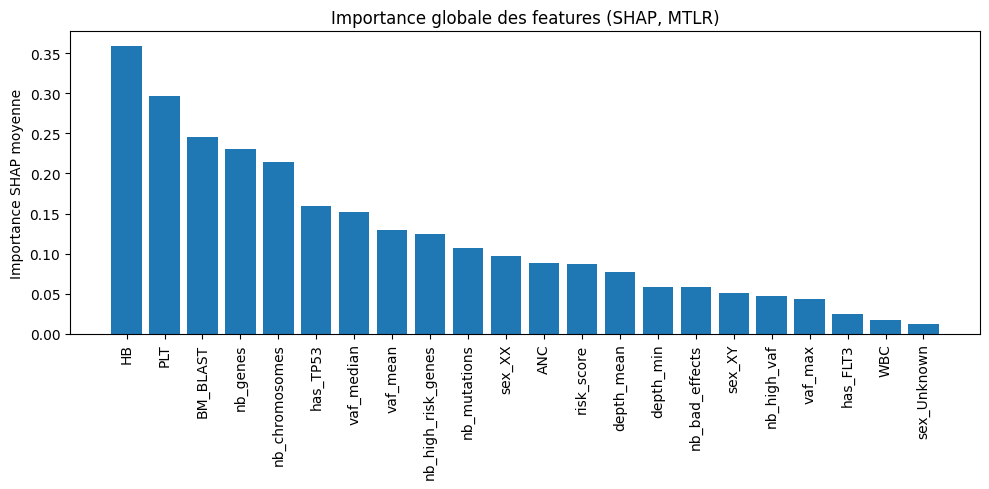

In [181]:
import shap
import torch

# Prend un échantillon du train pour l'explication (par exemple 100 points)
background = torch.tensor(X_features.values[:100], dtype=torch.float32)
test_sample = torch.tensor(X_features.values[100:120], dtype=torch.float32)  # 20 exemples à expliquer

# Le modèle doit être en mode évaluation
model.eval()

# Crée l'explainer SHAP
explainer = shap.DeepExplainer(model, background)

# Calcule les valeurs SHAP pour le test_sample
shap_values = explainer.shap_values(test_sample)


# 1) Calcul de l’importance SHAP
if isinstance(shap_values, list):
    # Liste de tableaux (n_samples, n_features) : même logique qu'avant
    per_output = [np.mean(np.abs(sv), axis=0) for sv in shap_values]   # list de (n_features,)
    feature_importance = np.mean(per_output, axis=0)                   # → (n_features,)
else:
    # Array 3D (n_samples, n_features, n_outputs)
    feature_importance = np.mean(np.abs(shap_values), axis=(0, 2))     # → (n_features,)

# 2) Récupération des noms de features
features = np.array(X_features.columns)


# 4) Tri et plot
sorted_idx = np.argsort(feature_importance)[::-1]
plt.figure(figsize=(10, 5))
plt.bar(features[sorted_idx], feature_importance[sorted_idx])
plt.xticks(rotation=90)
plt.title("Importance globale des features (SHAP, MTLR)")
plt.ylabel("Importance SHAP moyenne")
plt.tight_layout()
plt.show()


In [156]:
import pandas as pd

# Création du tableau d'importance trié
df_importance = pd.DataFrame({
    "feature": features[sorted_idx],
    "importance": feature_importance[sorted_idx]
}).reset_index(drop=True)

# Affichage markdown pour LLM
print("\nTableau markdown pour LLM :\n")
print(df_importance.to_markdown(index=False))


Tableau markdown pour LLM :

| feature            |   importance |
|:-------------------|-------------:|
| HB                 |   0.377889   |
| PLT                |   0.309606   |
| BM_BLAST           |   0.302452   |
| nb_genes           |   0.29807    |
| vaf_median         |   0.227149   |
| vaf_mean           |   0.199448   |
| nb_high_risk_genes |   0.181015   |
| nb_chromosomes     |   0.163731   |
| sex_XX             |   0.154031   |
| has_TP53           |   0.132366   |
| nb_mutations       |   0.116961   |
| depth_mean         |   0.106056   |
| depth_min          |   0.0807436  |
| ANC                |   0.0768705  |
| sex_XY             |   0.0754467  |
| nb_high_vaf        |   0.0617925  |
| vaf_max            |   0.0605787  |
| nb_bad_effects     |   0.0585936  |
| risk_score         |   0.0500447  |
| has_FLT3           |   0.0327786  |
| WBC                |   0.0246241  |
| total_chromosomes  |   0.0231008  |
| sex_Unknown        |   0.0123398  |
| nb_good_genes     